### Extract and clean time series data

First, we need to get and clean some financial data. Create a function `
def fetch_log_returns(start: str,end: str, tickers: str = '^GSPC ^FTSE ^N225 ^GDAXI ^IBEX') -> pd.DataFrame:` in `utils.py` that pulls daily pricing data from Yahoo finance and returns a pandas DataFrame with the daily log returns of every asset. 
- Use `yfinance.download()` to get the data from the already defined stock indeces
- See **logarithmic returns** definition in  (1)

In [1]:
from utils import fetch_log_returns
training_dataset = fetch_log_returns(start = '1995-01-01', end ='1995-12-31')

[*********************100%***********************]  5 of 5 completed


In [2]:
training_dataset.head()

,sp500,dax,ftse,nikkei,ibex
Date,,,,,
1995-01-05 00:00:00+00:00,-0.000803,-0.010397,-0.006345,-0.003457,-0.019565
1995-01-06 00:00:00+00:00,0.000738,0.003280,0.010726,-0.004939,0.000000
1995-01-09 00:00:00+00:00,0.000326,-0.002330,-0.003006,-0.003826,-0.014346
1995-01-10 00:00:00+00:00,0.001843,0.004213,0.001504,0.002903,-0.005274
1995-01-11 00:00:00+00:00,-0.000043,-0.000155,-0.003601,0.002408,-0.010125


### Define the problem instance and model parameters

Must of the functions you will be asked to build depend on those values, so it is important to understand its meaning. 

In [3]:
from model_params import LAMBDA_1, LAMBDA_2, LAMBDA_3, NLAYERS, NSHOTS, NUM_ASSETS, SIGMA_TARGET, TWO_QUBIT_GATES, K, N, RISK_FREE_RATE

### Build the circuit Ansatz (without angle embedding)

The ansatz is to Variational Quantum Algorithms what the neural network in Deep Learning. It is the mathematical structure that is supposed to adapt its structure according to the data is being fed with. We propose the most standard ansatz, the Hardware Efficient. See Section V. 

Build a function `build_hardware_efficient_ansatz(num_qubits: int = N, num_layers: int = NLAYERS, two_gate: str = "CNOT") -> models.Circuit` in `ansatz.py` that returns a Qibo circuit with the same structure as in FIG 2. Check that it works for different number of qubits, layers and two-qubit gates.

In [4]:
from ansatz import build_hardware_efficient_ansatz
ansatz = build_hardware_efficient_ansatz()
print('Hardware efficient circuit ansatz')
print()
print(ansatz.draw())


Hardware efficient circuit ansatz

q0: ─U2─U2─o───────U1─M─
q1: ─U2─U2─X─o─────U1─M─
q2: ─U2─U2───X─o───U1─M─
q3: ─U2─U2─────X─o─U1─M─
q4: ─U2─U2───────X─U1─M─


### Build the Portfolio Optimization Hamiltonian and run the optimization process


This is the most important part of the challenge. Here you'll learn how to map the finance problem to an Ising Hamiltonian. This is, how to translate a financial problem such that it can be solved using a quantum computer. 

First, create a function `compute_number_of_params_hwea(num_qubits: int, num_layers: int) -> int` in `utils.py` that returns the number of parameters needed the HWEA depending on the number of qubits and layers it has. You'll use it give random initial parameters to your algorithm.

Secondly, we need to create a function that returns the energy, as it plays the role of a loss function during the optimization process. `compute_total_energy(parameters: list[float], circuit, dataset: pd.DataFrame, nshots = NSHOTS, num_qubits = N) -> float` in `cost_function.py` is presented in (7). Make sure you understand its meaning.. In order to build it, we suggest to first define some auxiliar functions:

- `compute_return_energy(result: qibo.result.CircuitResult, dataset: pd.DataFrame, nshots: int = NSHOTS) -> float`
- `compute_risk_energy(result: qibo.result.CircuitResult, dataset: pd.DataFrame, nshots: int = NSHOTS) -> float`
- `compute_normalization_energy(result: qibo.result.CircuitResult, nshots: int = NSHOTS) -> float`

which in turn may use the following functions:

- `A(i: int, bit_string: list[int]) -> float`
- `return_cost_function(dataset: pd.DataFrame, bit_string: list[int]) -> float`
- `tilde_sigma(i: int,j: int, dataset: pd.DataFrame) -> float`
- `risk_cost_function(dataset: pd.DataFrame, bit_string: list[int]) -> float`
- `normalization_cost_function(bit_string: list[int]) -> float`
- `compute_cost_function(dataset: pd.DataFrame, bit_string: list[int]) -> float`

Check their docstring at `cost_function.py` to understand what they are supposed to do. 

What is the **difference between the cost function and the energy functions** in the context of this notebook? While both are closely related to (7), energy functions are built upon cost functions. When one measures a quantum state -e.g, the ansatz- one obtains a bitstring. As quantum is a probabilistic theory, several measurements of the same quantum state (after recreating it! Recall that quantum stats are destroyed when we measure them) may deliver different bitstrings. In order to account for the contribution of the different possible bistrings to the energy of the state, we need to measure several times (nshots!) and perform some basic statistic. Basically, we need to take into account the contribution of each bitstring to the total energy. This what the energy functions are supposed to do. The key here is to use `qibo.result.frequencies()`.


Once `compute_total_energy` is built, it's time to use it. 

First, generate the correct amount of angles between 0 and 2pi and set them as initial parameters of the optimization process. 

Secondly, generate the ansatz. 

Finally, use `qibo.optimizers.optimize` method to run an optimization process. You'll get then a set of optimal parameters. As the optimizsation process may take long, it is suggested to start with a small problem instance so you can test your code fast. 

In [14]:
import numpy as np
from qibo.optimizers import optimize
from cost_function import compute_total_energy
from ansatz import build_hardware_efficient_ansatz, compute_number_of_params_hwea


# Optimize starting from a random guess for the variational parameters
initial_params = np.random.uniform(0, 2*np.pi, compute_number_of_params_hwea(N,NLAYERS))

circuit = build_hardware_efficient_ansatz()
# perform optimization
best, optimal_params, extra = optimize(compute_total_energy, initial_params, args=(circuit, training_dataset))

# set final solution to circuit instance
print('Ground state energy:', best)
print()
print('Optimal parameters', optimal_params)
print()
print('Optimization process info', extra)

Energy: 163.37031657532134
Energy: 164.60370239410872
Energy: 181.4919680313481
Energy: 158.0638374129503
Energy: 156.5971438453641
Energy: 158.45472567323372
Energy: 151.45881858057115
Energy: 154.69162636933595
Energy: 154.94203314831995
Energy: 158.06501480446553
Energy: 157.30002416672136
Energy: 153.75513061305787
Energy: 157.14424081472677
Energy: 154.31749887522088
Energy: 153.36469156448464
Energy: 151.755912228535
Energy: 156.75301142190668
Energy: 155.14403855641808
Energy: 155.2388994319426
Energy: 157.7690362869693
Energy: 156.12787684028504
Energy: 154.08300853058137
Energy: 156.94135483616722
Energy: 155.86442581228113
Energy: 155.11415409253152
Energy: 151.42718370108486
Energy: 154.22365211045096
Energy: 150.56867068813526
Energy: 151.45851008883758
Energy: 150.74080214941088
Energy: 152.05127621859268
Energy: 149.22543010625057
Energy: 151.03611808552859
Energy: 151.16171953585646
Energy: 151.25580466672602
Energy: 152.1771265520846
Energy: 148.8189605389522
Energy: 14

### Results parsing


Since the optimization process has finished, we have to parse the results to undertand which portfolio is the algorithm suggesting. 

Define `get_optimal_binary_portfolios_prob_and_energy(ansatz: Circuit, dataset: pd.DataFrame, nshots: int = NSHOTS, tolerance: int = TOLERANCE) -> dict` in `results_parsing.py`. It takes the ansatz and measures it. Then, it returns the portfolios that turned out to have a certain probability. The threshold is defined as `max_prob - docstring_probability < TOLERANCE`. 

In [20]:
from results_parsing import get_optimal_binary_portfolios_prob_and_energy

optimized_ansatz = ansatz.set_parameters(optimal_params)
optimal_binary_portfolios = get_optimal_binary_portfolios_prob_and_energy(ansatz, training_dataset)
optimal_binary_portfolios


{'10111': {'stat_freq': 0.95, 'energy': 126.61415781311035}}

Define `get_minimum_energy(portfolios: dict) -> float` such that you know which is the minimal energy among all the proposed portfolios. Use it to determine which is the Mininum energy portfolio in the form of a bitstring.

In [7]:
from results_parsing import get_binary_portfolio, get_minimum_energy, get_decimal_portfolio

min_energy = get_minimum_energy(optimal_binary_portfolios)
min_energy_portfolio = ''
for portfolio, data in optimal_binary_portfolios.items(): 
    if data['energy'] == min_energy: 
        min_energy_portfolio = portfolio
print('Minimum energy portfolio:',min_energy_portfolio)


Minimum energy portfolio: 10111


Create `get_binary_portfolio(assets: list, ordered_bitstring, num_qubit_per_asset = K) -> dict` such that when receiving the minimum energy portfolio bitstring, it returns the corresponding portfolio as a dictionary.

In [8]:
binary_porfolio = get_binary_portfolio(training_dataset.columns, min_energy_portfolio)
binary_porfolio

{'sp500': '1', 'dax': '0', 'ftse': '1', 'nikkei': '1', 'ibex': '1'}

 Build `get_decimal_portfolio(binary_portfolio: dict) -> dict`

In [9]:

portfolio = get_decimal_portfolio(binary_porfolio)
portfolio

{'sp500': 0.25, 'dax': 0.0, 'ftse': 0.25, 'nikkei': 0.25, 'ibex': 0.25}

It may have happened that the portfolio is not normalized. To understand if it is reasonable, compute the amount of discretization or granularity. This is, the minimal increments that asset weights can have depending on the number of qubits you assign to them. 

In [10]:
from utils import granularity
granularity()

0.5

### Calculating portfolio metrics

Finally, it's time to assess the performance of the proposed portfolio. Develop `get_portfolio_metrics(portfolio: dict, dataset: pd.DataFrame, r: float = RISK_FREE_RATE) -> dict`. It should return a dictionary with the annualized return, volatility, Sharpe Ratio and normalized weights of the portfolio.

In [11]:
from results_parsing import get_portfolio_metrics
get_portfolio_metrics(portfolio, training_dataset)

{'Returns': 0.15815601813840685,
 'Volatility': 0.08943465659826202,
 'Sharpe Ratio': 1.432957010324086,
 'Normalized Weights': array([0.25, 0.  , 0.25, 0.25, 0.25])}

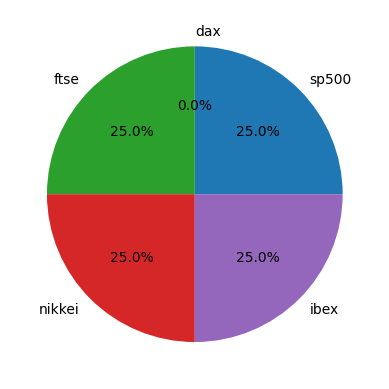

In [12]:
import matplotlib.pyplot as plt
sizes = portfolio.values()
fig, ax = plt.subplots()
ax.pie(sizes, labels=list(portfolio.keys()), autopct='%1.1f%%')
plt.show()

A explicar en el README: 

- crear entorno conda python 3.12, install requirements y clonar repo. 

Como encarar el challenge? 
1. explicar la situacion de que llego tarde
2. read the paper in diagonal until section V. Todo eso ya está resuelto. Consultarlo encase de duda. que es lo importante? entender como mapear el problema, por eso doy el codigo, intentad avanzar rápido. 
3. Al estar modularizado, podéis trabajar en paralelo en el desarollo de funciones. Teneis un docstring detallado y los tipos de lo que se espera a la entrada y la salida. 

Parte fácil NO guiada: 
- Resolver por fuerza bruta para ver lo mala que es la optimización pero lo precisa que es la formulación
- Como compara la solución de tu algortimo con los datos históricos? Benchnarking
- MonteCarlo for PO

Para hacer por libre si sabes mucho: 

- Trainable -> unsupervised quantum machine learning
- Reservoir computing